In [2]:
import pandas as pd

from protrend.utils import NeoDatabase, Settings
from protrend.model import *

In [3]:
neo_db = NeoDatabase(user_name=Settings.db_user_name, password=Settings.db_password,
                     ip=Settings.db_ip, port=Settings.db_port)
neo_db.connect()

In [4]:
dfs = []
labels = ['Effector',
          'Evidence',
          'Gene',
          'Operon',
          'Organism',
          'Pathway',
          'Publication',
          'Regulator',
          'RegulatoryFamily',
          'RegulatoryInteraction',
          'TFBS']
for label in labels:
    res = neo_db.db.cypher_query(f"match(s:Source)-[]-(t:{label}) return s.name, count(distinct(t.protrend_id))")
    df = pd.DataFrame(res[0], columns=['Source', 'Objects'])
    dfs.append(df)

In [5]:
df = pd.concat(dfs, keys=labels).reset_index(drop=False)
df = df.drop(columns=['level_1'])
df

,level_0,Source,Objects
0,Effector,regprecise,308
1,Effector,bsub_faria_et_al_2017,140
2,Effector,regulondb,68
3,Gene,collectf,1973
4,Gene,regprecise,101921
5,Gene,abasy,8184
6,Gene,coryneregnet,3845
7,Gene,bsub_faria_et_al_2017,1844
8,Gene,ecol_fang_et_al_2017,2190
9,Gene,mtub_turkarslan_et_al_2015,774


In [37]:
data = pd.pivot_table(df, values='Objects', index=['level_0'], columns=['Source'])
data = data.fillna(0)
data['Literature'] = data['bsub_faria_et_al_2017'] + data['ecol_fang_et_al_2017'] + data['mtub_turkarslan_et_al_2015']
data = data.drop(columns=['bsub_faria_et_al_2017', 'ecol_fang_et_al_2017', 'mtub_turkarslan_et_al_2015'])
data['total'] = data.sum(axis=1)
data = data.div(data.total, axis=0) * 100
data = data.rename(index={'RegulatoryFamily': 'R.Fam', 'RegulatoryInteraction': 'Interaction'})
data.index.name = 'Entity'
data.columns = ['Abasy', 'CollecTF', 'CoryneRegNet', 'DBTBS', 'ODB', 'RegPrecise', 'RegulonDB', 'Literature', 'Total']
data = data.drop(columns=['Total'])
data

,Abasy,CollecTF,CoryneRegNet,DBTBS,ODB,RegPrecise,RegulonDB,Literature
Entity,,,,,,,,
Effector,0.000000,0.000000,0.000000,0.000000,0.000000,59.689922,13.178295,27.131783
Gene,5.908002,1.424302,2.775692,0.483671,9.472005,73.576420,2.889030,3.470879
Operon,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000
Organism,0.881057,15.418502,0.587372,0.146843,9.691630,72.687225,0.146843,0.440529
Pathway,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000
Regulator,3.221909,1.259997,3.060814,0.627122,0.000000,87.687705,1.104655,3.037800
R.Fam,0.000000,0.000000,0.000000,3.846154,0.000000,0.000000,96.153846,0.000000
Interaction,5.181115,1.160306,4.112315,0.532112,0.000000,78.289097,5.208567,5.516487
TFBS,0.000000,2.358697,5.511969,1.207503,0.000000,84.398814,6.523018,0.000000


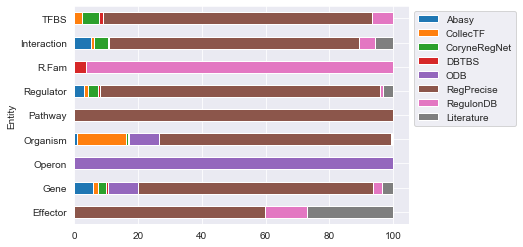

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
data.plot.barh(stacked=True, color=sns.color_palette('pastel').as_hex())
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.savefig("source_report.png", bbox_inches="tight", dpi=150)
plt.show()

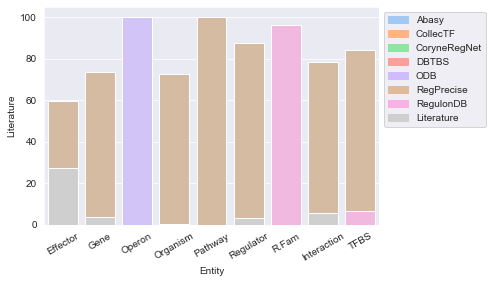

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

data_bar = data.reset_index(drop=False)
data_bar.columns = ['Entity', 'Abasy', 'CollecTF', 'CoryneRegNet', 'DBTBS', 'ODB', 'RegPrecise', 'RegulonDB', 'Literature', 'Total']

pal = sns.color_palette('pastel')

handles=[]
for i, src in enumerate(['Abasy', 'CollecTF', 'CoryneRegNet', 'DBTBS', 'ODB', 'RegPrecise', 'RegulonDB', 'Literature']):
    color = pal[i]

    bar = sns.barplot(x='Entity',  y=src, data=data_bar, color=color)
    bar.set_xticklabels(bar.get_xticklabels(), rotation=30)

    handle = mpatches.Patch(color=color, label=src)
    handles.append(handle)

# add legend
plt.legend(handles=handles, loc='upper left', bbox_to_anchor=(1,1), ncol=1)

# show the graph
plt.show()

In [14]:
# data_bar = data_bar.rolling(2, axis=1, min_periods=1, center=False).sum()
data_bar

,Entity,Abasy,CollecTF,CoryneRegNet,DBTBS,ODB,RegPrecise,RegulonDB,Literature
0,Effector,0.000000,0.000000,0.000000,0.000000,0.000000,59.689922,13.178295,27.131783
1,Gene,5.908002,1.424302,2.775692,0.483671,9.472005,73.576420,2.889030,3.470879
2,Operon,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000
3,Organism,0.881057,15.418502,0.587372,0.146843,9.691630,72.687225,0.146843,0.440529
4,Pathway,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000
5,Regulator,3.221909,1.259997,3.060814,0.627122,0.000000,87.687705,1.104655,3.037800
6,R.Fam,0.000000,0.000000,0.000000,3.846154,0.000000,0.000000,96.153846,0.000000
7,Interaction,5.181115,1.160306,4.112315,0.532112,0.000000,78.289097,5.208567,5.516487
8,TFBS,0.000000,2.358697,5.511969,1.207503,0.000000,84.398814,6.523018,0.000000


In [43]:
sns.color_palette('pastel')

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

In [22]:
data_bar = data_bar.drop(columns=['Total'])
data_bar.plot.barh(stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

KeyError: "['Total'] not found in axis"